JAX detected devices: [CudaDevice(id=0)]

══════════════════════════════════════════════════════════════════════
                   LEVER 0.1.0 - S-Space Evolution                    
══════════════════════════════════════════════════════════════════════

System: H2O_631g
  Orbitals: 13 | α: 5 | β: 5
  E_nuc: 9.19546682 Ha

Model: WavefunctionModel (Holomorphic: False)
  Cycles: 10 | S-size: 400 | Steps/cycle: 1000
  Learning rate: 0.0005
  Evaluation modes:
    Variational: every
    T-space CI: never
    S-space CI: final

──────────────────────────────────────────────────────────────────────
Evolution Progress
──────────────────────────────────────────────────────────────────────

Cycle 1/10 | S: 1 | C: 682 | H_SS: 1 | H_SC: 634
  Cycle 1 | Step   50/1000 | E = -74.42409045 Ha
  Cycle 1 | Step  100/1000 | E = -74.42541149 Ha
  Cycle 1 | Step  150/1000 | E = -74.42565308 Ha
  Cycle 1 | Step  200/1000 | E = -74.42591618 Ha
  Cycle 1 | Step  250/1000 | E = -74.42658130 Ha
  Cycle 1 | S

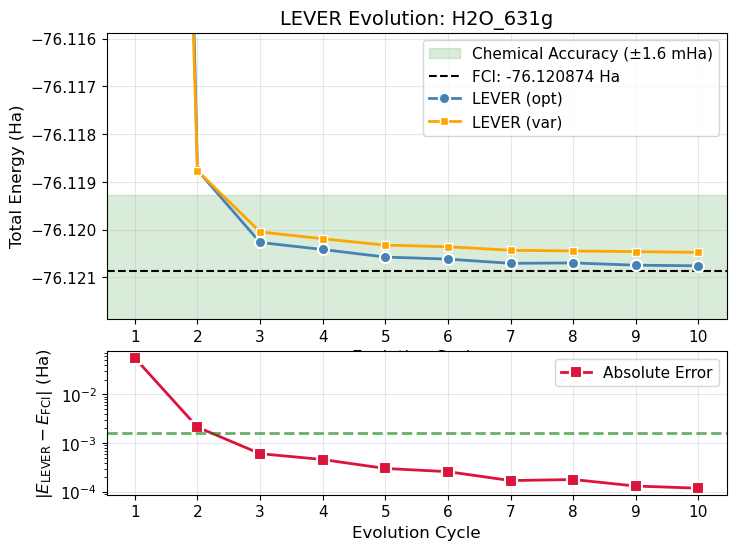

In [2]:
# Copyright 2025 The LEVER Authors - All rights reserved.
# SPDX-License-Identifier: Apache-2.0

"""
Iterative S-space evolution for LEVER wavefunction optimization.

Amplitude-based determinant selection with AdamW optimizer, validated against
exact FCI and optional T/S-space CI evaluation.

File: examples/run_evolution.py
Author: Zheng (Alex) Che, email: wsmxcz@gmail.com
Date: January, 2025
"""

from __future__ import annotations

import time
from enum import Enum
from pathlib import Path
from typing import Any

import jax
print("JAX detected devices:", jax.devices())
jax.config.update("jax_platforms", "cuda")
jax.config.update("jax_log_compiles", False)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import lever
from lever import engine, core


# ========================================================================
# Evaluation Mode Configuration
# ========================================================================

class EvalMode(Enum):
    """Timing control for energy evaluations during evolution"""
    NEVER = "never"  # Disable evaluation
    FINAL = "final"  # Evaluate only at final cycle
    EVERY = "every"  # Evaluate every cycle


# ========================================================================
# Configuration
# ========================================================================

CONFIG = {
    'fcidump_path': "../benchmark/FCIDUMP/H2O_631g.FCIDUMP",
    'n_orbitals': 13,
    'n_alpha': 5,
    'n_beta': 5,
    'seed': 42,
    'learning_rate': 5e-4,
    'num_cycles': 10,
    's_space_size': 400,
    'steps_per_cycle': 1000,
    'report_interval': 50,
  
    # Evaluation modes
    'var_energy_mode': EvalMode.EVERY,  # Variational energy ⟨ψ|H_T|ψ⟩/⟨ψ|ψ⟩
    'T_CI_energy_mode': EvalMode.NEVER,  # T-space CI via H_T diagonalization
    'S_CI_energy_mode': EvalMode.FINAL,  # S-space CI via H_SS diagonalization
}

ENGINE_CONFIG = engine.EngineConfig(
    compute_dtype=jnp.float64,
    energy_mode=engine.EnergyMode.PROXY,
    grad_mode=engine.GradMode.PROXY,
)


# ========================================================================
# Core Functions
# ========================================================================

def get_hf_determinant(n_orb: int, n_a: int, n_b: int) -> np.ndarray:
    """Construct HF reference: |HF⟩ = |1...n_α⟩ ⊗ |1...n_β⟩ as bit string."""
    return np.array([[(1 << n_a) - 1, (1 << n_b) - 1]], dtype=np.uint64)


def compute_fci_energy(
    int_ctx: lever.IntCtx,
    n_orb: int,
    n_a: int,
    n_b: int,
) -> float:
    """
    Exact ground state via FCI Hamiltonian diagonalization.

    Returns electronic energy (excludes E_nuc) using sparse Lanczos algorithm.
    """
    fci_dets = lever.core.gen_fci_dets(n_orb, n_a, n_b)
    ham_fci = engine.hamiltonian.get_ham_ss(
        S_dets=fci_dets, int_ctx=int_ctx, n_orbitals=n_orb
    )
    
    H_csr = sp.coo_matrix(
        (ham_fci.vals, (ham_fci.rows, ham_fci.cols)), shape=ham_fci.shape
    ).tocsr()
    H_csr.sum_duplicates()

    evals, _ = spla.eigsh(H_csr, k=1, which='SA', tol=1e-15, ncv=200, maxiter=3000)
    return float(evals[0])


def diagonalize_hamiltonian(ham: Any, e_nuc: float) -> float:
    """
    Ground state via sparse Hamiltonian diagonalization.
    
    Handles edge cases: single determinant or very small matrices.
    
    Returns:
        Total energy (E_elec + E_nuc)
    """
    # Handle trivial case: single determinant
    if ham.shape[0] == 1:
        return float(ham.vals[0]) + e_nuc
    
    H_csr = sp.coo_matrix(
        (ham.vals, (ham.rows, ham.cols)), shape=ham.shape
    ).tocsr()
    H_csr.sum_duplicates()

    # Ensure ncv is valid: must satisfy k < ncv < n for eigsh
    ncv = min(200, H_csr.shape[0] - 1)
    if ncv <= 1:
        # Matrix too small for sparse eigsh, use dense diagonalization
        H_dense = H_csr.toarray()
        evals = np.linalg.eigvalsh(H_dense)
        return float(evals[0]) + e_nuc
    
    evals, _ = spla.eigsh(H_csr, k=1, which='SA', tol=1e-12, ncv=ncv, maxiter=3000)
    return float(evals[0]) + e_nuc



def compute_variational_energy(
    variables: Any,
    logpsi_fn: callable,
    ham: Any,
    dets: np.ndarray,
    n_orb: int,
    e_nuc: float,
) -> float:
    """
    Variational energy ⟨ψ|H|ψ⟩/⟨ψ|ψ⟩ for given determinant space.

    Args:
        variables: Model parameters
        logpsi_fn: Amplitude function
        ham: Hamiltonian in determinant basis
        dets: Determinant configurations
        n_orb: Number of orbitals
        e_nuc: Nuclear repulsion energy

    Returns:
        Total energy (E_elec + E_nuc)
    """
    t_vecs = engine.utils.masks_to_vecs(jnp.asarray(dets), n_orb)
    log_psi = logpsi_fn(variables, t_vecs)
    psi = np.array(jnp.exp(log_psi))

    h_psi = engine.kernels.coo_matvec(
        ham.rows, ham.cols, ham.vals, psi, len(dets)
    )
    e_elec = np.vdot(psi, h_psi).real / np.vdot(psi, psi).real
    return e_elec + e_nuc


def should_evaluate(mode: EvalMode, current_cycle: int, total_cycles: int) -> bool:
    """Determine if evaluation should occur at current cycle."""
    if mode == EvalMode.NEVER:
        return False
    if mode == EvalMode.FINAL:
        return current_cycle == total_cycles - 1
    return True  # EvalMode.EVERY


# ========================================================================
# Optimization
# ========================================================================

def _create_jitted_step_fn(
    logpsi_fn: callable,
    ham_ss: Any,
    ham_sc: Any,
    space_rep: Any,
    n_orb: int,
    e_nuc: float,
    optimizer: optax.GradientTransformation,
    engine_config: engine.EngineConfig,
):
    """Factory for JIT-compiled optimization step capturing static data."""

    def step_fn(variables: Any, opt_state: Any) -> tuple[Any, Any, float]:
        """Single optimization step with energy/gradient computation."""
        evaluator = engine.Evaluator(
            params=variables,
            logpsi_fn=logpsi_fn,
            ham_ss=ham_ss,
            ham_sc=ham_sc,
            space=space_rep,
            n_orbitals=n_orb,
            config=engine_config,
        )

        result = engine.compute_energy_and_gradient(evaluator)
        updates, new_opt_state = optimizer.update(result.gradient, opt_state, variables)
        new_variables = optax.apply_updates(variables, updates)

        return new_variables, new_opt_state, result.energy_elec + e_nuc

    return jax.jit(step_fn)


def run_optimization_cycle(
    variables: Any,
    logpsi_fn: callable,
    ham_ss: Any,
    ham_sc: Any,
    space_rep: Any,
    n_orb: int,
    e_nuc: float,
    num_steps: int,
    lr: float,
    cycle_num: int,
    report_freq: int,
) -> tuple[Any, list[float]]:
    """Gradient descent within fixed S-C space partition."""
    optimizer = optax.adamw(lr)
    opt_state = optimizer.init(variables)

    jitted_step = _create_jitted_step_fn(
        logpsi_fn, ham_ss, ham_sc, space_rep, n_orb, e_nuc, optimizer, ENGINE_CONFIG
    )

    energy_history = []
    for step in range(num_steps):
        variables, opt_state, total_energy = jitted_step(variables, opt_state)
        energy_history.append(float(total_energy))

        if (step + 1) % report_freq == 0:
            print(f"  Cycle {cycle_num} | Step {step+1:4d}/{num_steps} | E = {total_energy:.8f} Ha")

    return variables, energy_history


# ========================================================================
# Visualization
# ========================================================================

def create_convergence_plot(
    energy_hist: list[float],
    cycle_bounds: list[int],
    exact_energy: float,
    var_energies: list[float] | None,
    t_ci_energies: list[float] | None,
    s_ci_energies: list[float] | None,
    system_name: str,
) -> None:
    """Dual-panel plot: energy trajectory and logarithmic error convergence."""
    plt.rcParams.update({
        'font.size': 11,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'lines.linewidth': 2.0,
        'grid.alpha': 0.3,
    })

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(8, 6),
        height_ratios=[2, 1],
        gridspec_kw={'hspace': 0.15}
    )

    energy = np.array(energy_hist)
    cycle_end_steps = [b - 1 for b in cycle_bounds[1:]]
    cycle_end_energies = [energy[idx] for idx in cycle_end_steps]
    cycle_end_errors = [abs(e - exact_energy) for e in cycle_end_energies]

    chem_acc = 1.6e-3  # 1 kcal/mol
    cycle_indices = np.arange(1, len(cycle_end_steps) + 1)

    # Energy trajectory panel
    ax1.axhspan(
        exact_energy - chem_acc, exact_energy + chem_acc,
        alpha=0.15, color='green', label='Chemical Accuracy (±1.6 mHa)'
    )
    ax1.axhline(exact_energy, color='black', linestyle='--', linewidth=1.5,
                label=f'FCI: {exact_energy:.6f} Ha')

    ax1.plot(cycle_indices, cycle_end_energies, 'o-', color='steelblue',
             markersize=8, markeredgecolor='white', markeredgewidth=1.5, 
             label='LEVER (opt)')

    # Optional energy curves
    if var_energies:
        var_indices = np.arange(1, len(var_energies) + 1)
        ax1.plot(var_indices, var_energies, 's-', color='orange',
                 markersize=6, markeredgecolor='white', markeredgewidth=1.0, 
                 label='LEVER (var)')

    # if t_ci_energies:
    #     t_ci_indices = np.arange(1, len(t_ci_energies) + 1)
    #     ax1.plot(t_ci_indices, t_ci_energies, '^-', color='purple',
    #              markersize=6, markeredgecolor='white', markeredgewidth=1.0,
    #              label='T-space CI')

    # if s_ci_energies:
    #     s_ci_indices = np.arange(1, len(s_ci_energies) + 1)
    #     ax1.plot(s_ci_indices, s_ci_energies, 'v-', color='red',
    #              markersize=6, markeredgecolor='white', markeredgewidth=1.0,
    #              label='S-space CI')

    ax1.set_ylim(exact_energy - 1e-3, exact_energy + 5e-3)
    ax1.set_ylabel('Total Energy (Ha)')
    ax1.set_xlabel('Evolution Cycle')
    ax1.set_title(f'LEVER Evolution: {system_name}')
    ax1.legend(loc='upper right')
    ax1.grid(True)
    ax1.set_xticks(cycle_indices)

    # Logarithmic error panel
    ax2.semilogy(cycle_indices, cycle_end_errors, 's-', color='crimson',
                 markersize=8, markeredgecolor='white', markeredgewidth=1.5,
                 label='Absolute Error')
    ax2.axhline(chem_acc, color='green', linestyle='--', alpha=0.6)

    ax2.set_xlabel('Evolution Cycle')
    ax2.set_ylabel(r'$|E_{\mathrm{LEVER}} - E_{\mathrm{FCI}}|$ (Ha)')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    ax2.set_xticks(cycle_indices)

    plt.show()


# ========================================================================
# Main Workflow
# ========================================================================

def main() -> None:
    cfg = CONFIG
    print(f"\n{'═' * 70}")
    print(f"LEVER {lever.__version__} - S-Space Evolution".center(70))
    print(f"{'═' * 70}\n")

    # System setup
    int_ctx = lever.IntCtx(cfg['fcidump_path'], cfg['n_orbitals'])
    int_ctx.hb_prepare()
    e_nuc = int_ctx.get_e_nuc()
    system_name = Path(cfg['fcidump_path']).stem

    print(f"System: {system_name}")
    print(f"  Orbitals: {cfg['n_orbitals']} | α: {cfg['n_alpha']} | β: {cfg['n_beta']}")
    print(f"  E_nuc: {e_nuc:.8f} Ha\n")

    # Model initialization
    model = lever.models.Backflow(
        n_orbitals=cfg['n_orbitals'],
        n_alpha=cfg['n_alpha'],
        n_beta=cfg['n_beta'],
        seed=cfg['seed'],
        generalized=True,
        restricted=False,
        hidden_dims=(256,),
        param_dtype=jnp.complex64
    )

    variables = model.variables

    print(f"Model: {model.__class__.__name__} (Holomorphic: {model.is_holo})")
    print(f"  Cycles: {cfg['num_cycles']} | S-size: {cfg['s_space_size']} | "
          f"Steps/cycle: {cfg['steps_per_cycle']}")
    print(f"  Learning rate: {cfg['learning_rate']:.4f}")
    print(f"  Evaluation modes:")
    print(f"    Variational: {cfg['var_energy_mode'].value}")
    print(f"    T-space CI: {cfg['T_CI_energy_mode'].value}")
    print(f"    S-space CI: {cfg['S_CI_energy_mode'].value}\n")

    # Evolution loop
    s_dets = get_hf_determinant(cfg['n_orbitals'], cfg['n_alpha'], cfg['n_beta'])
    full_history = []
    cycle_boundaries = [0]
  
    # Track energies per cycle (only for cycles where computed)
    var_energy_history = []
    t_ci_energy_history = []
    s_ci_energy_history = []

    t_start = time.time()
    print(f"{'─' * 70}")
    print("Evolution Progress")
    print(f"{'─' * 70}")

    for cycle in range(cfg['num_cycles']):
        # Build Hamiltonian for current S-space
        ham_ss, ham_sc, space_rep = engine.hamiltonian.get_ham_proxy(
            S_dets=s_dets,
            int_ctx=int_ctx,
            n_orbitals=cfg['n_orbitals'],
            use_heatbath=True,
            eps1=1e-3
        )

        print(f"\nCycle {cycle + 1}/{cfg['num_cycles']} | "
              f"S: {space_rep.size_S} | C: {space_rep.size_C} | "
              f"H_SS: {len(ham_ss.vals):,} | H_SC: {len(ham_sc.vals):,}")

        # Optimize within current S-C partition
        variables, cycle_history = run_optimization_cycle(
            variables=variables,
            logpsi_fn=model.log_psi,
            ham_ss=ham_ss,
            ham_sc=ham_sc,
            space_rep=space_rep,
            n_orb=cfg['n_orbitals'],
            e_nuc=e_nuc,
            num_steps=cfg['steps_per_cycle'],
            lr=cfg['learning_rate'],
            cycle_num=cycle + 1,
            report_freq=cfg['report_interval'],
        )

        full_history.extend(cycle_history)
        cycle_boundaries.append(len(full_history))
        print(f"  Optimization energy: {cycle_history[-1]:.8f} Ha")

        # Conditional evaluations based on mode settings
      
        # S-space CI evaluation
        if should_evaluate(cfg['S_CI_energy_mode'], cycle, cfg['num_cycles']):
            e_s_ci = diagonalize_hamiltonian(ham_ss, e_nuc)
            s_ci_energy_history.append(e_s_ci)
            print(f"  S-space CI: {e_s_ci:.8f} Ha")
      
        # T-space evaluations (var + CI)
        if (should_evaluate(cfg['var_energy_mode'], cycle, cfg['num_cycles']) or
            should_evaluate(cfg['T_CI_energy_mode'], cycle, cfg['num_cycles'])):
          
            # Build T-space Hamiltonian (S ∪ C)
            t_dets = np.concatenate([space_rep.s_dets, space_rep.c_dets])
            ham_tt = engine.hamiltonian.get_ham_ss(
                S_dets=t_dets, int_ctx=int_ctx, n_orbitals=cfg['n_orbitals'], 
            )
          
            # Variational energy
            if should_evaluate(cfg['var_energy_mode'], cycle, cfg['num_cycles']):
                e_var = compute_variational_energy(
                    variables=variables,
                    logpsi_fn=model.log_psi,
                    ham=ham_tt,
                    dets=t_dets,
                    n_orb=cfg['n_orbitals'],
                    e_nuc=e_nuc,
                )
                var_energy_history.append(e_var)
                print(f"  Variational energy: {e_var:.8f} Ha")
          
            # T-space CI
            if should_evaluate(cfg['T_CI_energy_mode'], cycle, cfg['num_cycles']):
                e_t_ci = diagonalize_hamiltonian(ham_tt, e_nuc)
                t_ci_energy_history.append(e_t_ci)
                print(f"  T-space CI: {e_t_ci:.8f} Ha | Size: {len(t_dets)}")

        # Update S-space via amplitude selection
        if cycle < cfg['num_cycles'] - 1:
            evaluator = engine.Evaluator(
                params=variables,
                logpsi_fn=model.log_psi,
                ham_ss=ham_ss,
                ham_sc=ham_sc,
                space=space_rep,
                n_orbitals=cfg['n_orbitals'],
                config=ENGINE_CONFIG,
            )
            psi_s, psi_c = evaluator.wavefunction

            all_scores = np.abs(np.concatenate([psi_s, psi_c]))
            all_dets = np.concatenate([space_rep.s_dets, space_rep.c_dets])

            num_select = min(cfg['s_space_size'], len(all_scores))
            top_indices = np.argsort(all_scores)[-num_select:]
            s_dets = all_dets[top_indices]

    elapsed = time.time() - t_start
    final_energy = full_history[-1]

    # Final analysis
    print(f"\n{'─' * 70}")
    print("Final Analysis")
    print(f"{'─' * 70}\n")

    # FCI reference
    e_fci = -76.12087434594531  # Precomputed for H2O/6-31G
    # e_fci = -462.00988015296525     # Precomputed for LiCl
    # e_fci = -87.892693 # Precomputed for Li2O
    
    # e_fci_elec = compute_fci_energy(int_ctx, cfg['n_orbitals'], cfg['n_alpha'], cfg['n_beta'])
    # e_fci = e_fci_elec + e_nuc
    print(f"Reference Energy:")
    print(f"  FCI: {e_fci:.8f} Ha\n")

    # Display all computed energies with gaps
    print(f"LEVER Results:")
    print(f"  Optimization final: {final_energy:.8f} Ha "
          f"(gap: {(final_energy - e_fci) * 1e3:+.4f} mHa)")
  
    if var_energy_history:
        print(f"  Variational final: {var_energy_history[-1]:.8f} Ha "
              f"(gap: {(var_energy_history[-1] - e_fci) * 1e3:+.4f} mHa)")
  
    if t_ci_energy_history:
        print(f"  T-space CI final: {t_ci_energy_history[-1]:.8f} Ha "
              f"(gap: {(t_ci_energy_history[-1] - e_fci) * 1e3:+.4f} mHa)")
  
    if s_ci_energy_history:
        print(f"  S-space CI final: {s_ci_energy_history[-1]:.8f} Ha "
              f"(gap: {(s_ci_energy_history[-1] - e_fci) * 1e3:+.4f} mHa)")
  
    print(f"  Evolution time: {elapsed:.2f} s\n")

    # Visualization
    create_convergence_plot(
        full_history, 
        cycle_boundaries, 
        e_fci,
        var_energy_history if var_energy_history else None,
        t_ci_energy_history if t_ci_energy_history else None,
        s_ci_energy_history if s_ci_energy_history else None,
        system_name
    )


if __name__ == "__main__":
    main()